<a href="https://colab.research.google.com/github/ShafeeqAhamedS/Exp3-Sobel-edge-detection-filter-using-CUDA-to-enhance-the-performance-of-image-processing-tasks./blob/main/Sobel_edge_detection_image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-qlz9m0ib
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-qlz9m0ib
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 28f872a2f99a1b201bcd0db14fdbc5a496b9bfd7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.2.1-py3-none-any.whl size=10743 sha256=3a570d3ab74e9051a615aa78d54722c78a69a0c83a1d407fccde14c37a30e96c
  Stored in directory: /tmp/pip-ephem-wheel-cache-biqq7ohn/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp4kgkq0c_".


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [3]:
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [4]:
from google.colab import files
uploaded = files.upload()

Saving images.jpg to images.jpg


In [12]:
from pathlib import Path

# Assuming the file is in the same directory as the notebook
file_path = Path('images.jpg')
if file_path.exists():
    print("File exists!")
else:
    print("File does not exist!")


File exists!


In [13]:
#ls -l /content/images.jpeg
import cv2
image = cv2.imread('/content/images.jpg')
if image is None:
    print("Error: Image not found or unable to read the image.")
else:
    print("Image read successfully.")


Image read successfully.


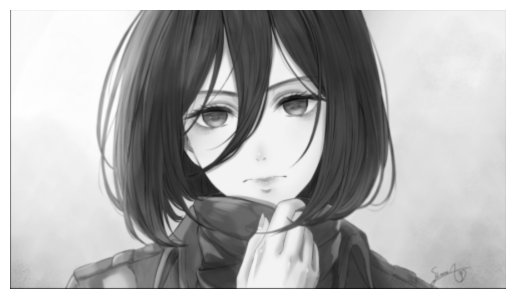

In [14]:
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [42]:
%%writefile sobelEdgeDetectionFilter.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda_runtime.h>
#include <opencv2/opencv.hpp>

using namespace cv;

__global__ void sobelFilter(unsigned char *srcImage, unsigned char *dstImage, unsigned int width, unsigned int height) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= 1 && x < width - 1 && y >= 1 && y < height - 1) {
        int Gx[3][3] = {{-1, 0, 1}, {-2, 0, 2}, {-1, 0, 1}};
        int Gy[3][3] = {{1, 2, 1}, {0, 0, 0}, {-1, -2, -1}};

        int sumX = 0;
        int sumY = 0;

        for (int i = -1; i <= 1; i++) {
            for (int j = -1; j <= 1; j++) {
                unsigned char pixel = srcImage[(y + i) * width + (x + j)];
                sumX += pixel * Gx[i + 1][j + 1];
                sumY += pixel * Gy[i + 1][j + 1];
            }
        }

        int magnitude = sqrtf(sumX * sumX + sumY * sumY);
        magnitude = min(max(magnitude, 0), 255);
        dstImage[y * width + x] = static_cast<unsigned char>(magnitude);
    }
}

void checkCudaErrors(cudaError_t r) {
    if (r != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s\n", cudaGetErrorString(r));
        exit(EXIT_FAILURE);
    }
}

int main() {
    Mat image = imread("/content/images.jpg", IMREAD_COLOR);
    if (image.empty()) {
        printf("Error: Image not found.\n");
        return -1;
    }

    // Convert to grayscale
    Mat grayImage;
    cvtColor(image, grayImage, COLOR_BGR2GRAY);

    int width = grayImage.cols;
    int height = grayImage.rows;
    size_t imageSize = width * height * sizeof(unsigned char);

    unsigned char *h_outputImage = (unsigned char *)malloc(imageSize);
    if (h_outputImage == nullptr) {
        fprintf(stderr, "Failed to allocate host memory\n");
        return -1;
    }

    unsigned char *d_inputImage, *d_outputImage;
    checkCudaErrors(cudaMalloc(&d_inputImage, imageSize));
    checkCudaErrors(cudaMalloc(&d_outputImage, imageSize));
    checkCudaErrors(cudaMemcpy(d_inputImage, grayImage.data, imageSize, cudaMemcpyHostToDevice));

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    dim3 blockSize(16, 16);
    dim3 gridSize(ceil(width / 16.0), ceil(height / 16.0));

    cudaEventRecord(start);
    sobelFilter<<<gridSize, blockSize>>>(d_inputImage, d_outputImage, width, height);
    cudaEventRecord(stop);

    cudaEventSynchronize(stop);

    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);

    checkCudaErrors(cudaMemcpy(h_outputImage, d_outputImage, imageSize, cudaMemcpyDeviceToHost));

    // Output image
    Mat outputImage(height, width, CV_8UC1, h_outputImage);
    imwrite("output_sobel.jpeg", outputImage);

    printf("Input Image Size: %d x %d\n", width, height);
    printf("Output Image Size: %d x %d\n", outputImage.cols, outputImage.rows);
    printf("Total time taken: %f milliseconds\n", milliseconds);

    free(h_outputImage);
    cudaFree(d_inputImage);
    cudaFree(d_outputImage);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);

    return 0;
}

Overwriting sobelEdgeDetectionFilter.cu


In [43]:
!nvcc -o sobelEdgeDetectionFilter sobelEdgeDetectionFilter.cu `pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [44]:
!./sobelEdgeDetectionFilter

Input Image Size: 891 x 502
Output Image Size: 891 x 502
Total time taken: 0.216256 milliseconds


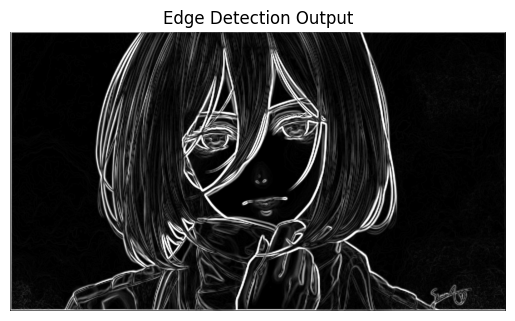

In [45]:
import cv2
from matplotlib import pyplot as plt

# Read and display the output image
output_image_path = '/content/output_sobel.jpeg'
output_image = cv2.imread(output_image_path, cv2.IMREAD_GRAYSCALE)  # Use IMREAD_GRAYSCALE if it's a single-channel image

# Display the image
plt.imshow(output_image, cmap='gray')
plt.title('Edge Detection Output')
plt.axis('off')  # Hide the axes
plt.show()